<a href="https://colab.research.google.com/github/magombe/Dashboard/blob/main/Context_Aware_System_with_Tavily_Chroma_LangChain_and_Gemini_Marktechpost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qU langchain-community tavily-python langchain-google-genai streamlit matplotlib pandas tiktoken chromadb langchain_core pydantic langchain

In [ ]:
import os
import getpass
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import time
from typing import List, Dict, Any, Optional
from datetime import datetime

In [ ]:
if "TAVILY_API_KEY" not in os.environ:
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter Tavily API key: ")

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter Google API key: ")

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [ ]:
from langchain_community.retrievers import TavilySearchAPIRetriever
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains.summarize import load_summarize_chain
from langchain.memory import ConversationBufferMemory

In [ ]:
class SearchQueryError(Exception):
    """Exception raised for errors in the search query."""
    pass

def format_docs(docs):
    formatted_content = []
    for i, doc in enumerate(docs):
        metadata = doc.metadata
        source = metadata.get('source', 'Unknown source')
        title = metadata.get('title', 'Untitled')
        score = metadata.get('score', 0)

        formatted_content.append(
            f"Document {i+1} [Score: {score:.2f}]:\n"
            f"Title: {title}\n"
            f"Source: {source}\n"
            f"Content: {doc.page_content}\n"
        )

    return "\n\n".join(formatted_content)

In [ ]:
class SearchResultsParser:
    def parse(self, text):
        try:
            if isinstance(text, str):
                import re
                import json
                json_match = re.search(r'\{.*\}', text, re.DOTALL)
                if json_match:
                    json_str = json_match.group(0)
                    return json.loads(json_str)
                return {"answer": text, "sources": [], "confidence": 0.5}
            elif hasattr(text, 'content'):
                return {"answer": text.content, "sources": [], "confidence": 0.5}
            else:
                return {"answer": str(text), "sources": [], "confidence": 0.5}
        except Exception as e:
            logger.warning(f"Failed to parse JSON: {e}")
            return {"answer": str(text), "sources": [], "confidence": 0.5}

In [ ]:
class EnhancedTavilyRetriever:
    def __init__(self, api_key=None, max_results=5, search_depth="advanced", include_domains=None, exclude_domains=None):
        self.api_key = api_key
        self.max_results = max_results
        self.search_depth = search_depth
        self.include_domains = include_domains or []
        self.exclude_domains = exclude_domains or []
        self.retriever = self._create_retriever()
        self.previous_searches = []

    def _create_retriever(self):
        try:
            return TavilySearchAPIRetriever(
                api_key=self.api_key,
                k=self.max_results,
                search_depth=self.search_depth,
                include_domains=self.include_domains,
                exclude_domains=self.exclude_domains
            )
        except Exception as e:
            logger.error(f"Failed to create Tavily retriever: {e}")
            raise

    def invoke(self, query, **kwargs):
        if not query or not query.strip():
            raise SearchQueryError("Empty search query")

        try:
            start_time = time.time()
            results = self.retriever.invoke(query, **kwargs)
            end_time = time.time()

            search_record = {
                "timestamp": datetime.now().isoformat(),
                "query": query,
                "num_results": len(results),
                "response_time": end_time - start_time
            }
            self.previous_searches.append(search_record)

            return results
        except Exception as e:
            logger.error(f"Search failed: {e}")
            raise SearchQueryError(f"Failed to perform search: {str(e)}")

    def get_search_history(self):
        return self.previous_searches

In [ ]:
class SearchCache:
    def __init__(self):
        self.embedding_function = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
        self.vector_store = None
        self.text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

    def add_documents(self, documents):
        if not documents:
            return

        try:
            if self.vector_store is None:
                self.vector_store = Chroma.from_documents(
                    documents=documents,
                    embedding=self.embedding_function
                )
            else:
                self.vector_store.add_documents(documents)
        except Exception as e:
            logger.error(f"Failed to add documents to cache: {e}")

    def search(self, query, k=3):
        if self.vector_store is None:
            return []

        try:
            return self.vector_store.similarity_search(query, k=k)
        except Exception as e:
            logger.error(f"Vector search failed: {e}")
            return []

In [ ]:
search_cache = SearchCache()
enhanced_retriever = EnhancedTavilyRetriever(max_results=5)
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

system_template = """You are a research assistant that provides accurate answers based on the search results provided.
Follow these guidelines:
1. Only use the context provided to answer the question
2. If the context doesn't contain the answer, say "I don't have sufficient information to answer this question."
3. Cite your sources by referencing the document numbers
4. Don't make up information
5. Keep the answer concise but complete

Context: {context}
Chat History: {chat_history}
"""

system_message = SystemMessagePromptTemplate.from_template(system_template)
human_template = "Question: {question}"
human_message = HumanMessagePromptTemplate.from_template(human_template)

prompt = ChatPromptTemplate.from_messages([system_message, human_message])

In [ ]:
def get_llm(model_name="gemini-2.0-flash-lite", temperature=0.2, response_mode="json"):
    try:
        return ChatGoogleGenerativeAI(
            model=model_name,
            temperature=temperature,
            convert_system_message_to_human=True,
            top_p=0.95,
            top_k=40,
            max_output_tokens=2048
        )
    except Exception as e:
        logger.error(f"Failed to initialize LLM: {e}")
        raise

output_parser = SearchResultsParser()

In [ ]:
def plot_search_metrics(search_history):
    if not search_history:
        print("No search history available")
        return

    df = pd.DataFrame(search_history)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(df)), df['response_time'], marker='o')
    plt.title('Search Response Times')
    plt.xlabel('Search Index')
    plt.ylabel('Time (seconds)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.bar(range(len(df)), df['num_results'])
    plt.title('Number of Results per Search')
    plt.xlabel('Search Index')
    plt.ylabel('Number of Results')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
def retrieve_with_fallback(query):
    cached_results = search_cache.search(query)

    if cached_results:
        logger.info(f"Retrieved {len(cached_results)} documents from cache")
        return cached_results

    logger.info("No cache hit, performing web search")
    search_results = enhanced_retriever.invoke(query)

    search_cache.add_documents(search_results)

    return search_results

def summarize_documents(documents, query):
    llm = get_llm(temperature=0)

    summarize_prompt = ChatPromptTemplate.from_template(
        """Create a concise summary of the following documents related to this query: {query}

        {documents}

        Provide a comprehensive summary that addresses the key points relevant to the query.
        """
    )

    chain = (
        {"documents": lambda docs: format_docs(docs), "query": lambda _: query}
        | summarize_prompt
        | llm
        | StrOutputParser()
    )

    return chain.invoke(documents)

In [ ]:
def advanced_chain(query_engine="enhanced", model="gemini-1.5-pro", include_history=True):
    llm = get_llm(model_name=model)

    if query_engine == "enhanced":
        retriever = lambda query: retrieve_with_fallback(query)
    else:
        retriever = enhanced_retriever.invoke

    def chain_with_history(input_dict):
        query = input_dict["question"]
        chat_history = memory.load_memory_variables({})["chat_history"] if include_history else []

        docs = retriever(query)

        context = format_docs(docs)

        result = prompt.invoke({
            "context": context,
            "question": query,
            "chat_history": chat_history
        })

        memory.save_context({"input": query}, {"output": result.content})

        return llm.invoke(result)

    return RunnableLambda(chain_with_history) | StrOutputParser()

In [ ]:
qa_chain = advanced_chain()

def analyze_query(query):
    llm = get_llm(temperature=0)

    analysis_prompt = ChatPromptTemplate.from_template(
        """Analyze the following query and provide:
        1. Main topic
        2. Sentiment (positive, negative, neutral)
        3. Key entities mentioned
        4. Query type (factual, opinion, how-to, etc.)

        Query: {query}

        Return the analysis in JSON format with the following structure:
        {{
            "topic": "main topic",
            "sentiment": "sentiment",
            "entities": ["entity1", "entity2"],
            "type": "query type"
        }}
        """
    )

    chain = analysis_prompt | llm | output_parser

    return chain.invoke({"query": query})

print("Advanced Tavily-Gemini Implementation")
print("="*50)

query = "what year was breath of the wild released and what was its reception?"
print(f"Query: {query}")

Advanced Tavily-Gemini Implementation
Query: what year was breath of the wild released and what was its reception?


Advanced Tavily-Gemini Implementation
Query: what year was breath of the wild released and what was its reception?

Searching for answer...


ERROR:__main__:Failed to add documents to cache: Expected metadata value to be a str, int, float, bool, or None, got [] which is a list in upsert.

Try filtering complex metadata from the document using langchain_community.vectorstores.utils.filter_complex_metadata.


Error in search: 'ChatPromptValue' object has no attribute 'content'

Search History:
1. Query: what year was breath of the wild released and what was its reception? - Results: 5 - Time: 1.55s

Advanced search with domain filtering:
Found 3 specialized results


/usr/local/lib/python3.11/dist-packages/langchain_google_genai/chat_models.py:390: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")



Summary of specialized results:
The documents primarily focus on "The Legend of Zelda" games, specifically mentioning "Breath of the Wild" and its sequel, "Tears of the Kingdom."  "Breath of the Wild" is available for purchase on the Nintendo Switch, as indicated by the Nintendo store links. "Tears of the Kingdom" is a direct sequel to "Breath of the Wild" and sold over 10 million copies worldwide in its first three days. The documents also mention related accessories for "Tears of the Kingdom."

Search Metrics:


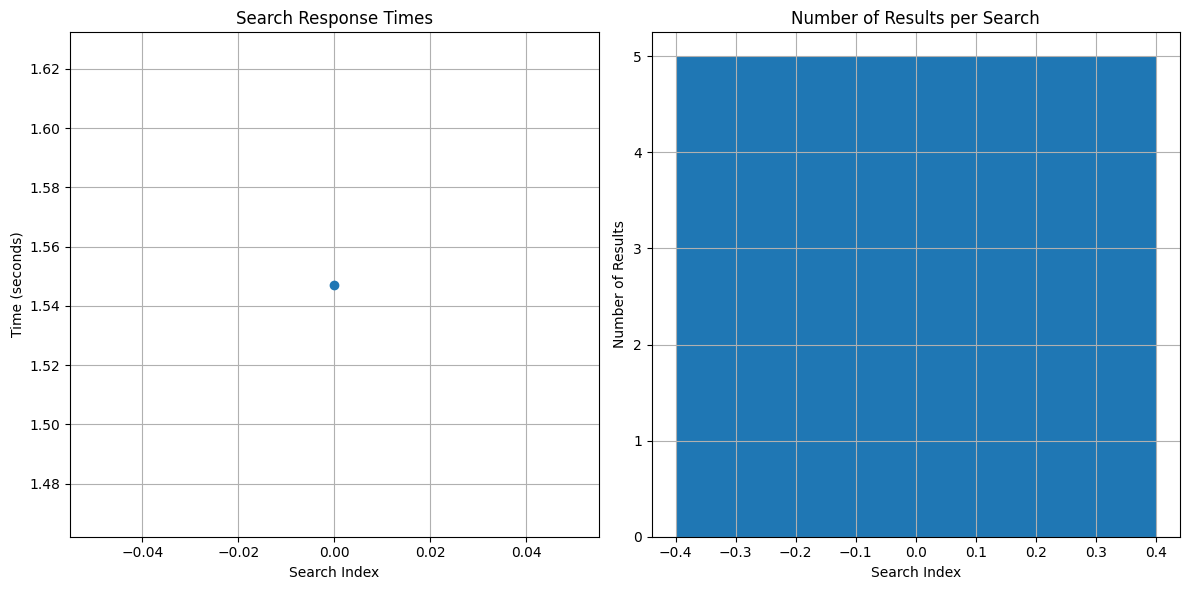

In [ ]:
try:
    print("\nSearching for answer...")
    answer = qa_chain.invoke({"question": query})
    print("\nAnswer:")
    print(answer)

    print("\nAnalyzing query...")
    try:
        query_analysis = analyze_query(query)
        print("\nQuery Analysis:")
        print(json.dumps(query_analysis, indent=2))
    except Exception as e:
        print(f"Query analysis error (non-critical): {e}")
except Exception as e:
    print(f"Error in search: {e}")

history = enhanced_retriever.get_search_history()
print("\nSearch History:")
for i, h in enumerate(history):
    print(f"{i+1}. Query: {h['query']} - Results: {h['num_results']} - Time: {h['response_time']:.2f}s")

print("\nAdvanced search with domain filtering:")
specialized_retriever = EnhancedTavilyRetriever(
    max_results=3,
    search_depth="advanced",
    include_domains=["nintendo.com", "zelda.com"],
    exclude_domains=["reddit.com", "twitter.com"]
)

try:
    specialized_results = specialized_retriever.invoke("breath of the wild sales")
    print(f"Found {len(specialized_results)} specialized results")

    summary = summarize_documents(specialized_results, "breath of the wild sales")
    print("\nSummary of specialized results:")
    print(summary)
except Exception as e:
    print(f"Error in specialized search: {e}")

print("\nSearch Metrics:")
plot_search_metrics(history)